Классификация

In [112]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler


# file_path = './online_shoppers_intention.csv'
file_path = './adult 3 (1).csv'

df = pd.read_csv(file_path)
df = df.replace('?', pd.NA).dropna()
print(f"Размер: {df.shape}")

Размер: (45222, 15)


income

In [113]:
df_only_num = df[['age', 'hours-per-week']]

print(df_only_num.describe())

numeric_columns = df_only_num.columns


for col in df_only_num.columns:
    mode_value = df_only_num[col].mode()
    if not mode_value.empty:
        print(f"Мода для столбца '{col}': {mode_value.iloc[0]}")
    else:
        print(f"Мода для столбца '{col}' не найдена.")

print("\nАсимметрия:")
for col in numeric_columns:
    skew_val = skew(df[col].dropna())
    print(f"{col:20s}: {skew_val:8.3f}")

print("\nЭксцесс:")
for col in numeric_columns:
    kurt_val = kurtosis(df[col].dropna())
    print(f"{col:20s}: {kurt_val:8.3f}")

                age  hours-per-week
count  45222.000000    45222.000000
mean      38.547941       40.938017
std       13.217870       12.007508
min       17.000000        1.000000
25%       28.000000       40.000000
50%       37.000000       40.000000
75%       47.000000       45.000000
max       90.000000       99.000000
Мода для столбца 'age': 36
Мода для столбца 'hours-per-week': 40

Асимметрия:
age                 :    0.533
hours-per-week      :    0.341

Эксцесс:
age                 :   -0.156
hours-per-week      :    3.201


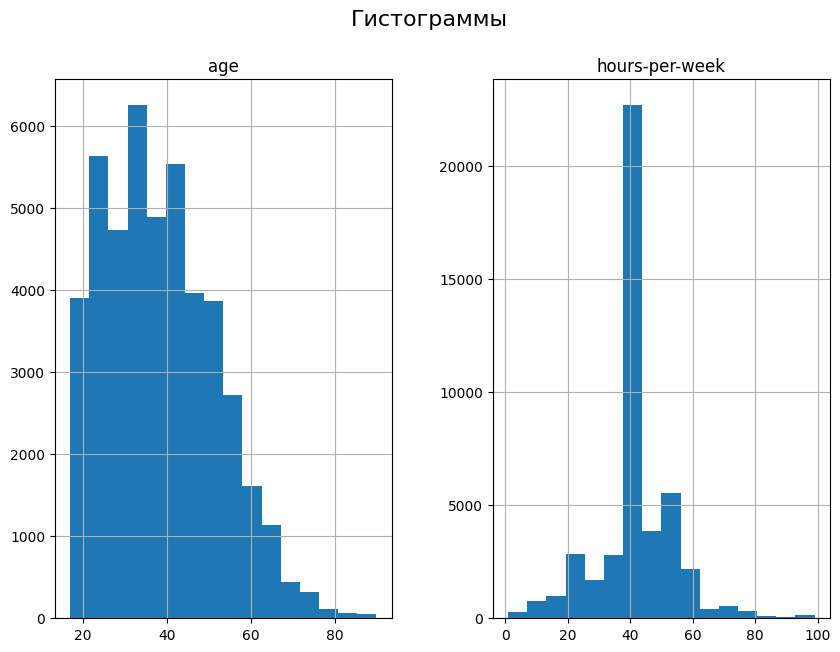

In [114]:

count_intervals = int(1 + math.log2(df_only_num.shape[0]))

df_only_num.hist(bins=count_intervals, figsize=(10, 7))
plt.suptitle("Гистограммы", fontsize=16)
plt.show()

In [115]:
df_only_categ = df[['income', 'educational-num', 'marital-status', 
                    'relationship', 'race', 'gender']]

for col in df_only_categ.columns:
    print(df_only_categ[col].value_counts(normalize=True) * 100)
    print("-" * 30)

income
<=50K    75.215603
>50K     24.784397
Name: proportion, dtype: float64
------------------------------
educational-num
9     32.689841
10    21.889788
13    16.739640
14     5.559241
11     4.331962
7      3.580116
12     3.332449
6      2.704436
4      1.819911
15     1.735881
5      1.494848
8      1.275928
16     1.202954
3      0.992880
2      0.490912
1      0.159215
Name: proportion, dtype: float64
------------------------------
marital-status
Married-civ-spouse       46.559197
Never-married            32.280748
Divorced                 13.924638
Separated                 3.120163
Widowed                   2.823847
Married-spouse-absent     1.220645
Married-AF-spouse         0.070762
Name: proportion, dtype: float64
------------------------------
relationship
Husband           41.276370
Not-in-family     25.876786
Own-child         14.652160
Unmarried         10.587767
Wife               4.623856
Other-relative     2.983061
Name: proportion, dtype: float64
-----------------

In [116]:
le = LabelEncoder()
df['income_num'] = le.fit_transform(df['income'])
df['marital_status_num'] = le.fit_transform(df['marital-status'])
df['relationship_num'] = le.fit_transform(df['relationship'])
df['race_num'] = le.fit_transform(df['race'])
df['gender_num'] = le.fit_transform(df['gender'])

print("\n income_num:")
print(sorted(df['income_num'].unique()))
print("\n marital_status_num:")
print(sorted(df['marital_status_num'].unique()))
print("\n relationship_num:")
print(sorted(df['relationship_num'].unique()))
print("\n race_num:")
print(sorted(df['race_num'].unique()))
print("\n gender_num:")
print(sorted(df['gender_num'].unique()))

columns_to_drop = ['income', 'fnlwgt', 'native-country', 'education',
                   'workclass', 'marital-status', 'occupation', 'relationship',
                   'race', 'gender', 'capital-gain', 'capital-loss']
df = df.drop(columns=columns_to_drop)

print("Столбцы после удаления:")
print(df.columns.tolist())


 income_num:
[np.int64(0), np.int64(1)]

 marital_status_num:
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

 relationship_num:
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

 race_num:
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

 gender_num:
[np.int64(0), np.int64(1)]
Столбцы после удаления:
['age', 'educational-num', 'hours-per-week', 'income_num', 'marital_status_num', 'relationship_num', 'race_num', 'gender_num']


In [118]:
scaler = StandardScaler()
df = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns
)

print("Средние значения после стандартизации:")
print(df.mean())

print("\nСтандартные отклонения после стандартизации:")
print(df.std())

Средние значения после стандартизации:
age                  -2.199725e-17
educational-num      -1.382685e-17
hours-per-week        3.142465e-18
income_num           -9.710217e-17
marital_status_num    5.970683e-18
relationship_num      1.964041e-18
race_num              1.854054e-17
gender_num           -1.311979e-17
dtype: float64

Стандартные отклонения после стандартизации:
age                   1.000011
educational-num       1.000011
hours-per-week        1.000011
income_num            1.000011
marital_status_num    1.000011
relationship_num      1.000011
race_num              1.000011
gender_num            1.000011
dtype: float64
